In [1]:
import pandas as pd
import numpy as np
import time 


import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pycountry  as pc



In [3]:
import os
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

df_prepro_og = pd.read_csv(os.path.abspath(parent_path + '/data/preprocessed_df.csv'))
print(df_prepro_og.shape)


#df_merged_og = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))
#print(df_merged_og.shape)

(55309, 103)


In [52]:
df_all = df_prepro_og.copy()

death_choice = 'deaths_all_intp_pop_pc'
conflict_choice = 'armedconf_intp_pop'

## Clusters for analyis
We use only data from 2000 to December 2017 to generate the clusters. Each country can only belong to one cluster.
- We aggregrate the data at the country level by taking the min/max/mean for existing variables as appropriate.
- We perform a principal component analysis as using the many columns directly provides an inconclusive picture of the optimal number of clusters.
- We apply k-means clustering to the PCA data and via the elbo method decide on 15 clusters.
- We list the countries in each cluster and visualise them in the 3D space of the three principal components.


In [96]:
# drop observations prior to 1989 (which is when UCDP data starts)
#df = df[df['year'] >= 1989]
#print(df.shape)

# check time period
print(df_all.year.min())
print(df_all.year.max())

print('number of countries:', df_all.isocode.nunique())
print('number rows without deaths', df_all.deaths.isna().sum())

print('target variables:', death_choice, conflict_choice)

2000
2023
number of countries: 197
number rows without deaths 0
target variables: deaths_all_intp_pop_pc armedconf_intp_pop


In [97]:
#  generate unique ID for each country in each month
df_all['country_month_id'] = df_all['MonthYear'].astype(str) + '_' + df['isocode']

In [89]:
# drop countries with with <413 Month Entries in GDELT
# exception: 'SSD'
# isocodes_to_drop = ['ABW', 'AIA', 'AND', 'ASM', 'BVT', 'COK', 'CXR', 'CYM', 'FLK', 'FRO', 'GGY', 'GLP', 'GUF', 'HMD', 'IMN', 'IOT', 'KIR', 'KNA', 'LCA', 'LIE', 'MTQ', 'MYT', 'NFK', 'NIU', 'NRU', 'PCN', 'PLW', 'PYF', 'REU', 'SHN', 'SJM', 'SMR', 'SPM', 'TCA', 'TKL', 'TUV', 'VCT', 'VGB', 'WLF']
# df = df[~df['isocode'].isin(isocodes_to_drop)]

# print('number of countries:', df.isocode.nunique())
# df.shape

number of countries: 201


(82258, 71)

In [98]:
pd.set_option('display.max_columns', None)

df_all.head(1)

,MonthYear,isocode,month,year,deaths,month_year,Country Name,deaths_all_intp_pop_pc,armedconf_intp_pop,past6,past12,past60,past120,armedconf_intp_pop_since,share_events_1,share_events_2,share_events_3,share_events_4,share_events_5,share_events_6,share_events_7,share_events_8,share_events_9,share_events_10,share_events_11,share_events_12,share_events_13,share_events_14,share_events_15,share_events_16,share_events_17,share_events_18,share_events_19,share_events_20,share_events_1_gov,share_events_2_gov,share_events_3_gov,share_events_4_gov,share_events_5_gov,share_events_6_gov,share_events_7_gov,share_events_8_gov,share_events_9_gov,share_events_10_gov,share_events_11_gov,share_events_12_gov,share_events_13_gov,share_events_14_gov,share_events_15_gov,share_events_16_gov,share_events_17_gov,share_events_18_gov,share_events_19_gov,share_events_20_gov,share_events_1_opp,share_events_2_opp,share_events_3_opp,share_events_4_opp,share_events_5_opp,share_events_6_opp,share_events_7_opp,share_events_8_opp,share_events_9_opp,share_events_10_opp,share_events_11_opp,share_events_12_opp,share_events_13_opp,share_events_14_opp,share_events_15_opp,share_events_16_opp,share_events_17_opp,share_events_18_opp,share_events_19_opp,share_events_20_opp,norm_total_events,event_share_1_stock,event_share_2_stock,event_share_3_stock,event_share_4_stock,event_share_5_stock,event_share_6_stock,event_share_7_stock,event_share_8_stock,event_share_9_stock,event_share_10_stock,event_share_11_stock,event_share_12_stock,event_share_13_stock,event_share_14_stock,event_share_15_stock,event_share_16_stock,event_share_17_stock,event_share_18_stock,event_share_19_stock,event_share_20_stock,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,share_state_deaths,share_nonstate_deaths,share_onesided_deaths,share_civilian_deaths,country_month_id
0,1970-01-01 00:00:00.000200001,AFG,1,2000,54.0,2000-01-01,Afghanistan,0.276314,True,0.276314,0.276314,0.276314,0.276314,0,11.485452,4.555896,7.274119,34.686064,8.996937,2.029096,2.105666,5.436447,0.497703,1.454824,5.321593,2.603369,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,13.567839,4.145729,10.552764,31.155779,9.673367,1.507538,1.38191,5.527638,0.502513,1.884422,3.894472,3.643216,0.879397,1.005025,0.125628,0.628141,2.638191,0.753769,6.532663,0.0,8.196721,6.557377,1.639344,24.590164,3.278689,0.0,3.278689,13.114754,0.0,4.918033,3.278689,1.639344,0.0,0.0,4.918033,0.0,8.196721,1.639344,14.754098,0.0,0.00675,11.485452,4.555896,7.274119,34.686064,8.996937,2.029096,2.105666,5.436447,0.497703,1.454824,5.321593,2.603369,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,640.329787,602.909299,602.123846,100.0,0.0,0.0,48.15,1970-01-01 00:00:00.000200001_AFG


#### Clustering



In [117]:
df = df_all.copy()
df = df.loc[df['year'] <= 2017]

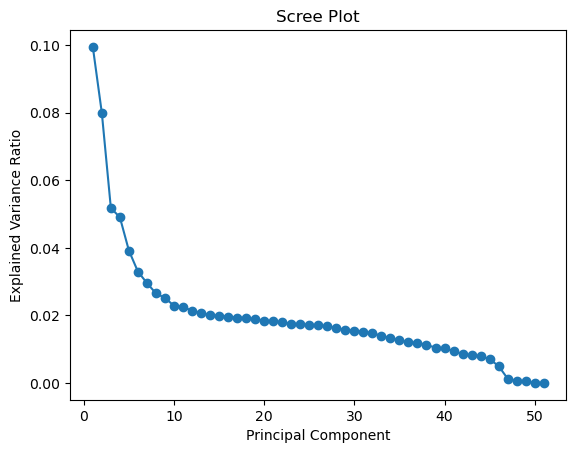

In [118]:
# # PCA monthy version

# X = df.drop(columns=[death_choice, conflict_choice], axis=1)  # Drop the target column from the features
# countries = X['isocode']

# X = X[[peace_count]+ death_share_cols + event_share_cols + event_stock_cols + past_cols +adm1_cols ]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# pca = PCA()
# X_pca = pca.fit_transform(X_scaled)

# explained_variance_ratio = pca.explained_variance_ratio_
# plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Scree Plot')
# plt.show()

# n_components = 3  # Set the desired number of components
# X_selected = X_pca[:, :n_components]

In [103]:
peace_count = conflict_choice + '_since'

death_share_cols = df.filter(like='_deaths').columns.tolist()
event_share_cols = ['share_events_{}'.format(i) for i in range(1, 21)] # NB not using _gov and _opp
event_stock_cols = ['event_share_{}_stock'.format(i) for i in range(1, 21)] 
past_cols = ['past6', 'past12',	'past60', 'past120']
adm1_cols = ['Adm1_Median', 'Adm1_Mean']


In [80]:
mean_max =  [death_choice] + [peace_count] + ['deaths'] # + past_cols + adm1_cols
max_only = ['num_regions'] # + []'Adm1_Max']

mean_only = [conflict_choice] + ['norm_total_events'] #['Adm1_Mean'] + death_share_cols + event_stock_cols
all_aggs = event_share_cols

In [81]:
cols_not_used = set(df.columns.tolist()) - set(mean_max + max_only + mean_only + all_aggs)
#cols_not_used

In [82]:
# Group the data by the country column
grouped_data = df.groupby('isocode')

In [88]:


agg_data1 = grouped_data.agg(agg_functions_max_only)
agg_data2 = grouped_data.agg(agg_functions_mean_max)
add_data3 = grouped_data.agg(agg_functions_mean_only)
add_data4 = grouped_data.agg(agg_functions_all_aggs)

# Merge aggregated dataframes - 1: deaths_pc, peacecount, total_deaths, 2: number of regions
aggregated_data = pd.merge(agg_data1, agg_data2, left_index=True, right_index=True)


#aggregated_data = pd.merge(aggregated_data, add_data3, left_index=True, right_index=True)
#aggregated_data = pd.merge(aggregated_data, add_data4, left_index=True, right_index=True)

# Print the aggregated data
aggregated_data.head(3)

num_regions deaths_all_intp_pop_pc           armedconf_intp_pop_since  \
                max                   mean       max                     mean   
isocode                                                                         
AFG              36               1.946701  8.527444                 0.013889   
AGO              21               0.086100  2.545510                21.902778   
ALB              14               0.000000  0.000000               108.500000   

                  deaths          
         max        mean     max  
isocode                           
AFG        1  582.476852  3018.0  
AGO       83   15.009259   441.0  
ALB      216    0.000000     0.0

In [119]:
aggregated_data.columns

MultiIndex([(             'num_regions',  'max'),
            (  'deaths_all_intp_pop_pc', 'mean'),
            (  'deaths_all_intp_pop_pc',  'max'),
            ('armedconf_intp_pop_since', 'mean'),
            ('armedconf_intp_pop_since',  'max'),
            (                  'deaths', 'mean'),
            (                  'deaths',  'max'),
            (                 'Cluster',     '')],
           )

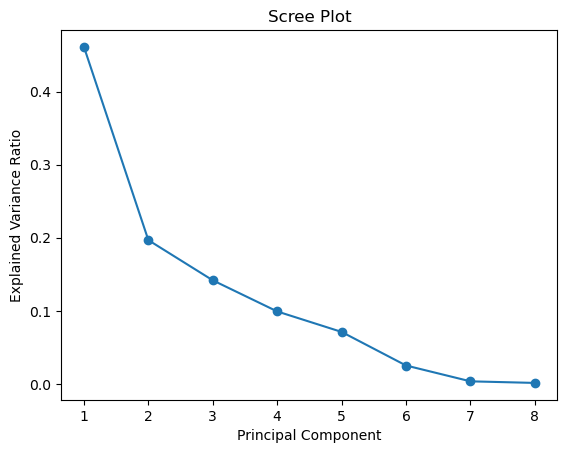

In [123]:
# PCA country level

# don't think we need to drop target as 'true' target in this case is the cluster

X = aggregated_data.copy()
country_labels = X.index

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

n_components = 3  # Set the desired number of components
X_selected = X_pca[:, :n_components]

In [128]:
pca_df = pd.DataFrame(X_selected, columns=['PC1', 'PC2', 'PC3'])  # Adjust column names as needed
pca_df['country'] = country_labels  # Add the country labels column
pca_df.set_index('country', inplace=True)  # Set the country column as the index
pca_df

,PC1,PC2,PC3
country,,,
AFG,7.484786,0.969101,0.395760
AGO,1.074560,-1.435198,0.039826
ALB,-1.088449,0.689095,-0.440701
ARE,-1.104751,0.766835,-0.547357
ARG,-0.889780,0.446155,1.667525
...,...,...,...
XKX,-0.869251,0.385114,1.726428
YEM,2.284473,-1.244602,0.625041
ZAF,-1.096912,0.736124,-0.504789


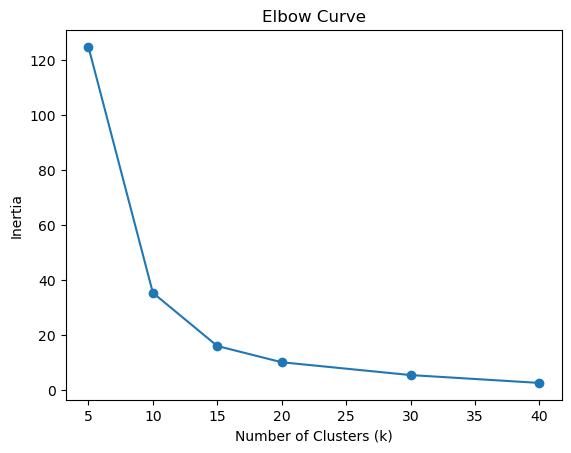

In [135]:

# slelect columns for clustering
#columns_for_clustering = ['deaths', 'norm_total_events'] + event_share_columns
data_pca = pca_df

# normalise data
scaler = StandardScaler()
normalized_data_pca = scaler.fit_transform(data_pca)

# pick cluster range
k_values = [5,10,15,20,30, 40] #range(1, 20)

# initialize list to store inertia values
inertia_values = []

#perform k-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=1000, init = 'k-means++')
    kmeans.fit(normalized_data_pca)
    inertia_values.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

In [136]:
# Determine the optimal number of clusters based on the elbow point
# In this example, let's assume the optimal number of clusters is 3
optimal_k = 15

# Perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=1000, init = 'k-means++')
kmeans.fit(normalized_data_pca)

# Assign observations to clusters
cluster_labels = kmeans.labels_

# Add cluster labels to the dataframe
data_pca['Cluster'] = cluster_labels

In [148]:
## CLusters based on many aggregated features
# cluster_0 = aggregated_data.loc[aggregated_data['Cluster'] == 0].index.tolist()
# cluster_1 = aggregated_data.loc[aggregated_data['Cluster'] == 1].index.tolist()
# cluster_2 = aggregated_data.loc[aggregated_data['Cluster'] == 2].index.tolist()
# cluster_3 = aggregated_data.loc[aggregated_data['Cluster'] == 3].index.tolist()
# cluster_4 = aggregated_data.loc[aggregated_data['Cluster'] == 4].index.tolist()
# cluster_5 = aggregated_data.loc[aggregated_data['Cluster'] == 5].index.tolist()


## Clusters based on PCA version of aggregated features
cluster_names = []
for i in range(0,15):
    print(f'cluster {i}' , data_pca.loc[data_pca['Cluster'] == i].index.tolist())

cluster 0 ['AZE', 'IND', 'JPN', 'LVA', 'MKD', 'MLT', 'SVN', 'VNM']
cluster 1 ['BEL', 'BFA', 'CMR', 'ECU', 'ESP', 'FRA', 'JAM', 'KWT', 'MAR', 'NAM', 'SLE', 'TGO', 'ZMB']
cluster 2 ['ERI', 'LBR']
cluster 3 ['BDI', 'LBY', 'LKA', 'SOM', 'SSD', 'TCD', 'YEM']
cluster 4 ['SYR']
cluster 5 ['ALB', 'ARE', 'ATG', 'AUS', 'AUT', 'BEN', 'BGD', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRB', 'BRN', 'BWA', 'CAN', 'COM', 'CPV', 'CRI', 'CYP', 'DMA', 'DNK', 'ESH', 'FJI', 'FSM', 'GAB', 'GIB', 'GNB', 'GNQ', 'GRD', 'GRL', 'GUM', 'HKG', 'ISL', 'LSO', 'LTU', 'LUX', 'MAC', 'MCO', 'MDV', 'MHL', 'MNE', 'MNP', 'MUS', 'NCL', 'NLD', 'OMN', 'PAN', 'PRI', 'PRK', 'PSE', 'QAT', 'SGP', 'SLB', 'SRB', 'STP', 'SUR', 'SVK', 'SWZ', 'SYC', 'TKM', 'TLS', 'TON', 'VIR', 'VUT', 'WSM', 'ZAF']
cluster 6 ['COD', 'ISR', 'MEX', 'MMR', 'NGA', 'PAK']
cluster 7 ['GBR', 'PHL']
cluster 8 ['AGO', 'CIV', 'COL', 'EGY', 'ETH', 'GIN', 'GTM', 'HND', 'IRN', 'KEN', 'LBN', 'MLI', 'SEN']
cluster 9 ['CAF', 'IRQ', 'SDN']
cluster 10 ['BRA', 'COG', 'DJI', 'GE

In [154]:
# Function to get country name from ISO code
def get_country_name(iso_code):
    try:
        country = pc.countries.get(alpha_3=iso_code)
        return country.name
    except AttributeError:
        return 'Unknown'

# Generate column of country names
data_pca['isocode'] = data_pca.index
data_pca['Country Name'] = data_pca['isocode'].apply(get_country_name)
data_pca

,PC1,PC2,PC3,Cluster,isocode,Country Name
country,,,,,,
AFG,7.484786,0.969101,0.395760,13,AFG,Afghanistan
AGO,1.074560,-1.435198,0.039826,8,AGO,Angola
ALB,-1.088449,0.689095,-0.440701,5,ALB,Albania
ARE,-1.104751,0.766835,-0.547357,5,ARE,United Arab Emirates
ARG,-0.889780,0.446155,1.667525,14,ARG,Argentina
...,...,...,...,...,...,...
XKX,-0.869251,0.385114,1.726428,14,XKX,Unknown
YEM,2.284473,-1.244602,0.625041,3,YEM,Yemen
ZAF,-1.096912,0.736124,-0.504789,5,ZAF,South Africa


In [160]:
cluster_names = []
for i in range(0,15):
    print(f'Cluster {i}' , data_pca.loc[data_pca['Cluster'] == i, 'Country Name'].tolist())

Cluster 0 ['Azerbaijan', 'India', 'Japan', 'Latvia', 'North Macedonia', 'Malta', 'Slovenia', 'Viet Nam']
Cluster 1 ['Belgium', 'Burkina Faso', 'Cameroon', 'Ecuador', 'Spain', 'France', 'Jamaica', 'Kuwait', 'Morocco', 'Namibia', 'Sierra Leone', 'Togo', 'Zambia']
Cluster 2 ['Eritrea', 'Liberia']
Cluster 3 ['Burundi', 'Libya', 'Sri Lanka', 'Somalia', 'South Sudan', 'Chad', 'Yemen']
Cluster 4 ['Syrian Arab Republic']
Cluster 5 ['Albania', 'United Arab Emirates', 'Antigua and Barbuda', 'Australia', 'Austria', 'Benin', 'Bangladesh', 'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda', 'Bolivia, Plurinational State of', 'Barbados', 'Brunei Darussalam', 'Botswana', 'Canada', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cyprus', 'Dominica', 'Denmark', 'Western Sahara', 'Fiji', 'Micronesia, Federated States of', 'Gabon', 'Gibraltar', 'Guinea-Bissau', 'Equatorial Guinea', 'Grenada', 'Greenland', 'Guam', 'Hong Kong', 'Iceland', 'Lesotho', 'Lithuania', 'Luxembourg', 'Macao', 'Monaco', 'Maldives', '

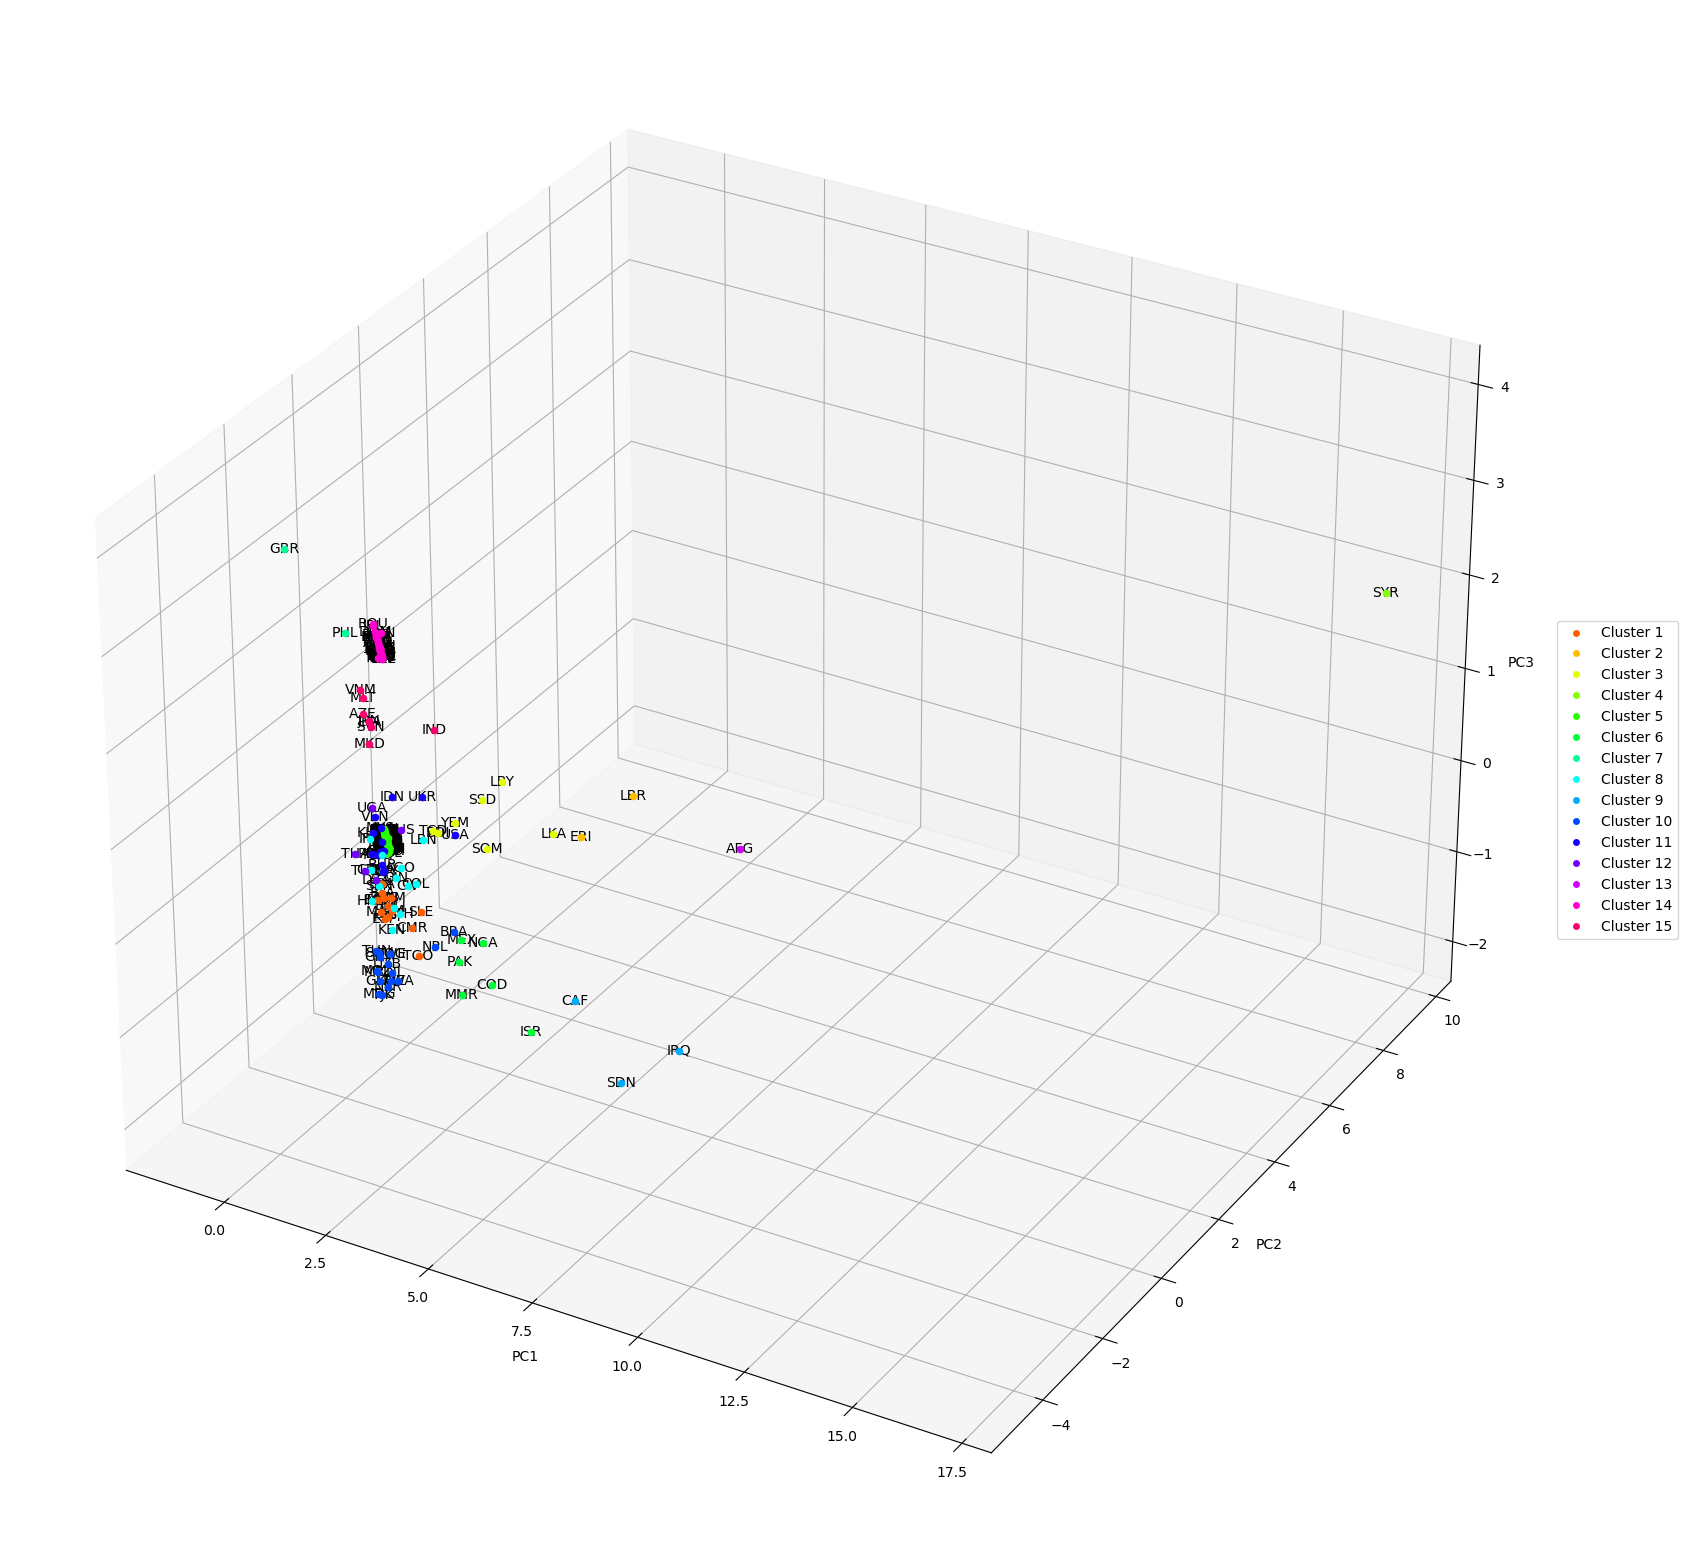

In [159]:


# Create a color palette with 15 distinct colors
num_clusters = data_pca['Cluster'].nunique()
palette = sns.color_palette('hsv', num_clusters)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

for index, row in data_pca.iterrows():
    cluster_color = palette[row['Cluster'] - 1]
    ax.scatter(row['PC1'], row['PC2'], row['PC3'], c=[cluster_color], label=row['isocode'])
    ax.text(row['PC1'], row['PC2'], row['PC3'], row['isocode'], color='black', fontsize=10, ha='center', va='center')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

legend_elements = []
for cluster_label, color in enumerate(palette, start=1):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=f'Cluster {cluster_label}'))

# Place the legend outside the graph
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


## Clustering to detect underlying states for HMM
- Allowing countries to be in multiple clusters
- For HMM state detection: generate clusters on monthly basis


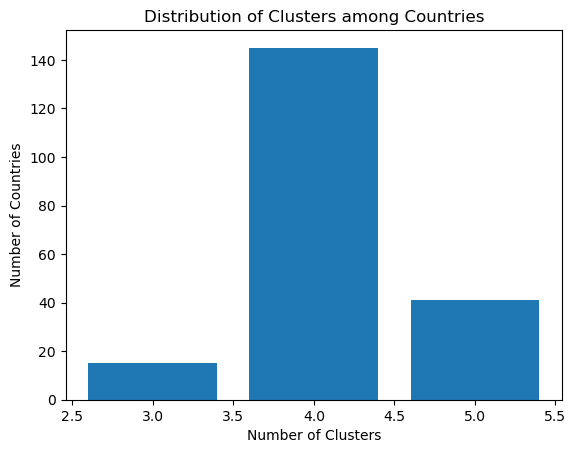

In [110]:
# Count the number of countries with 1, 2, and 3 clusters
cluster_counts = df.groupby('isocode')['Cluster'].nunique()
count_of_clusters = cluster_counts.value_counts().sort_index()

# Plot the bar chart
plt.bar(count_of_clusters.index, count_of_clusters.values)
plt.xlabel('Number of Clusters')
plt.ylabel('Number of Countries')
plt.title('Distribution of Clusters among Countries')
plt.xticks(rotation=0)
plt.show()


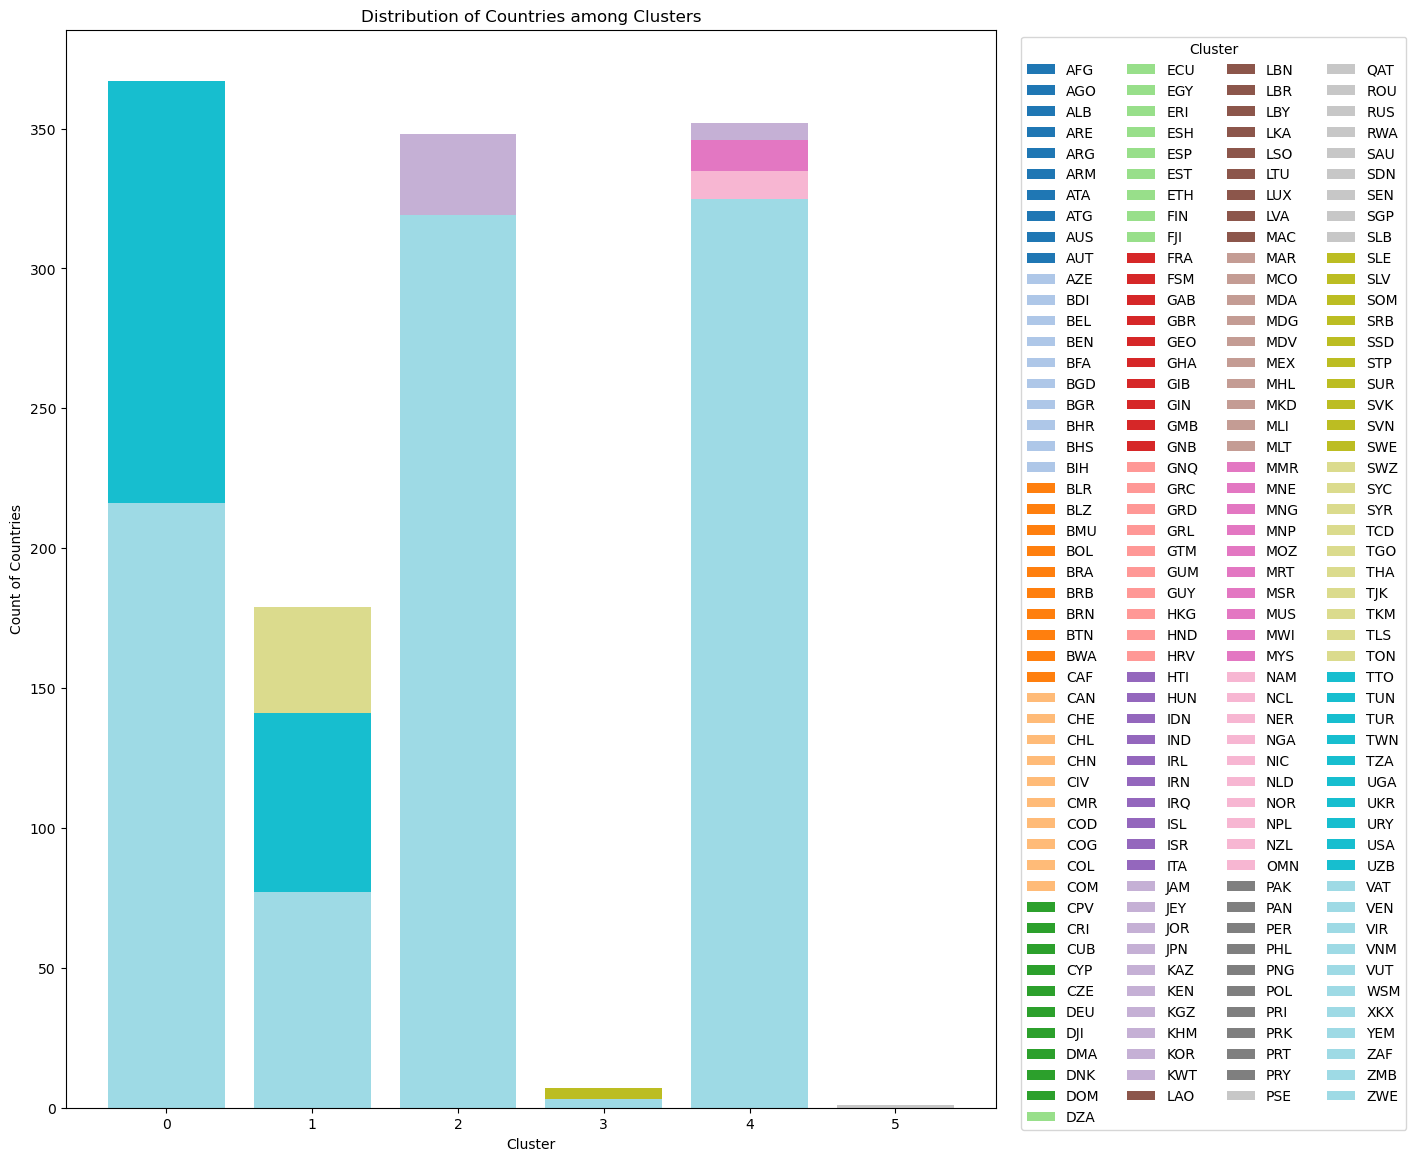

In [115]:
# Count the number of countries in each cluster
country_counts = df.groupby('Cluster')['isocode'].value_counts().unstack().fillna(0)

# Plot the large graph
plt.figure(figsize=(12,14))
colors = plt.cm.get_cmap('tab20', len(country_counts.columns))
for i, (column, color) in enumerate(zip(country_counts.columns, colors.colors)):
    plt.bar(country_counts.index, country_counts[column], label=column, color=color)
plt.xlabel('Cluster')
plt.ylabel('Count of Countries')
plt.title('Distribution of Countries among Clusters')

# Create a smaller legend in 4 columns on the side
legend_handles = [plt.bar(0, 0, color=color, label=label) for label, color in zip(country_counts.columns, colors.colors)]
plt.legend(handles=legend_handles, title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=4)

plt.show()

